In [3]:
import numpy as np
import matplotlib.pyplot as plt
from diskmodels import profilecirc
from diskfit import likelihood, utils
from scipy.optimize import minimize
import emcee

z = 0.0146
cont = np.array([-2.57426216e-06, -4.41129826e+00,  8.08577702e-16])

#### Functions

In [4]:
def power_law(wl, A, k, C):
    return A*(wl/(1+z))**k+C

def plot_linefit_circ_fixeddoublet_freeamplitudes_Halpha(theta, w, y, yerr, lines, fixed, fitted):
    fitted = dict(zip(fitted.keys(),theta)) 
    params = {**fitted, **fixed}
    x = w/(1+params['z'])
    xib0 = (params['xi2']-params['xi1'])*params['xib']+params['xi1'] 
    diskmodel = profilecirc.profile(params['maxstep'],params['xi1'],params['xi2'],params['broad'],params['q1'],params['q2'],xib0,params['angi']%180,params['anglam'],params['t0'],params['eta'],params['version'],params['amp'],params['narms'],params['aobs']%360,params['pitch'],params['width'],params['xispin'],params['xispout'],params['nstep'],params['relativistic'],params['olambda'],params['npix'],x)
    widths = np.hstack((np.ones(len(lines))*params['narrowwidth'],np.ones(len(lines))*params['narrowwidth2'])) 
    lineprofs1 = utils.build_doublet_profiles(x,lines[:len(lines)],widths[:len(lines)],params['ratios'])   
    lineprofs2 = utils.build_doublet_profiles(x,lines[:len(lines)],widths[len(lines):2*len(lines)],params['ratios'])    
    amps = [params['Halphaflux'],params['NIIbflux'],params['SIIbflux']]
    narrowmodel1 = lineprofs1[0] * amps[0]
    for line,amp in zip(lineprofs1[1:],amps[1:]):
        narrowmodel1+=line*amp 
    narrowmodel2 = lineprofs2[0] * amps[0]
    for line,amp in zip(lineprofs2[1:],amps[1:]):
        narrowmodel2+=line*amp 
    narrowmodel = np.sum((narrowmodel1,narrowmodel2),axis=0)
    diskout = diskmodel*params['diskflux']
    return diskout,narrowmodel

def model_linefit_circ_fixeddoublet_freeamplitudes_Halpha(theta, w, y, yerr, lines, fixed, fitted):
    fitted = dict(zip(fitted.keys(),theta)) 
    params = {**fitted, **fixed}
    x = w/(1+params['z'])
    xib0 = (params['xi2']-params['xi1'])*params['xib']+params['xi1'] 
    diskmodel = profilecirc.profile(params['maxstep'],params['xi1'],params['xi2'],params['broad'],params['q1'],params['q2'],xib0,params['angi']%180,params['anglam'],params['t0'],params['eta'],params['version'],params['amp'],params['narms'],params['aobs']%360,params['pitch'],params['width'],params['xispin'],params['xispout'],params['nstep'],params['relativistic'],params['olambda'],params['npix'],x)
    widths = np.hstack((np.ones(len(lines))*params['narrowwidth'],np.ones(len(lines))*params['narrowwidth2'])) 
    lineprofs1 = utils.build_doublet_profiles(x,lines[:len(lines)],widths[:len(lines)],params['ratios'])   
    lineprofs2 = utils.build_doublet_profiles(x,lines[:len(lines)],widths[len(lines):2*len(lines)],params['ratios'])    
    amps = [params['Halphaflux'],params['NIIbflux'],params['SIIbflux']]
    narrowmodel1 = lineprofs1[0] * amps[0]
    for line,amp in zip(lineprofs1[1:],amps[1:]):
        narrowmodel1+=line*amp 
    narrowmodel2 = lineprofs2[0] * amps[0]
    for line,amp in zip(lineprofs2[1:],amps[1:]):
        narrowmodel2+=line*amp 
    narrowmodel = np.sum((narrowmodel1,narrowmodel2),axis=0)
    diskout = diskmodel*params['diskflux']
    model = np.sum((diskout,narrowmodel),axis=0)
    return model

class log_prior(object):
    def __init__(self, mins, maxes):
        self.mins = mins
        self.maxes = maxes
    def __call__(self, theta): 

        if np.any(theta<self.mins) or np.any(theta>self.maxes): 
            return -np.inf
        return 0.0

class logprob_circ_fixeddoublet_freeamplitudes_Halpha(object):
    def __init__(self, x, y, yerr, lines, fixed, fitted, mins, maxes):   
        self.x = x
        self.y = y
        self.yerr = yerr
        self.lines = lines
        self.fixed = fixed
        self.fitted = fitted
        self.mins = mins
        self.maxes = maxes
        self.log_prior = log_prior(self.mins, self.maxes)
    def __call__(self,theta):
        lp = self.log_prior(theta)
        like = loglikelihood_circ_fixeddoublet_freeamplitudes_Halpha(theta, self.x, self.y, self.yerr, self.lines, self.fixed, self.fitted)
        if np.any(np.isnan(like)):
            #return np.full(len(like),1e10+lp)
            return -np.inf   
        #print(like,lp)
        return like+lp 
    def test(self,theta):
        modelout = model_linefit_circ_fixeddoublet_freeamplitudes_Halpha(theta, self.x, self.y, self.yerr, self.lines, self.fixed, self.fitted) 
        return modelout 
    def plot(self,theta):
        diskout,narrowout = plot_linefit_circ_fixeddoublet_freeamplitudes_Halpha(theta, self.x, self.y, self.yerr, self.lines, self.fixed, self.fitted) 
        return diskout,narrowout

def loglikelihood_circ_fixeddoublet_freeamplitudes_Halpha(theta, w, y, yerr, lines, fixed, fitted):
    fitted = dict(zip(fitted.keys(),theta)) 
    params = {**fitted, **fixed}
    x = w/(1+params['z'])
    xib0 = (params['xi2']-params['xi1'])*params['xib']+params['xi1'] 
    diskmodel = profilecirc.profile(params['maxstep'],params['xi1'],params['xi2'],params['broad'],params['q1'],params['q2'],xib0,params['angi']%180,params['anglam'],params['t0'],params['eta'],params['version'],params['amp'],params['narms'],params['aobs']%360,params['pitch'],params['width'],params['xispin'],params['xispout'],params['nstep'],params['relativistic'],params['olambda'],params['npix'],x)
    widths = np.hstack((np.ones(len(lines))*params['narrowwidth'],np.ones(len(lines))*params['narrowwidth2'])) 
    lineprofs1 = utils.build_doublet_profiles(x,lines[:len(lines)],widths[:len(lines)],params['ratios'])   
    lineprofs2 = utils.build_doublet_profiles(x,lines[:len(lines)],widths[len(lines):2*len(lines)],params['ratios'])    
    amps = [params['Halphaflux'],params['NIIbflux'],params['SIIbflux']]
    narrowmodel1 = lineprofs1[0] * amps[0]
    for line,amp in zip(lineprofs1[1:],amps[1:]):
        narrowmodel1+=line*amp 
    narrowmodel2 = lineprofs2[0] * amps[0]
    for line,amp in zip(lineprofs2[1:],amps[1:]):
        narrowmodel2+=line*amp 
    narrowmodel = np.sum((narrowmodel1,narrowmodel2),axis=0)
    diskout = diskmodel*params['diskflux']
    model = np.sum((diskout,narrowmodel),axis=0)
    sigma2 = yerr**2  
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))

#### Spec

In [5]:
fn = '../../spectra/AT2019qiz.txt'
wl_uncut, flux_uncut = np.loadtxt(fn, usecols=(0, 1), unpack=True)
wl_cutstart, wl_cutend = np.argmin(np.abs(wl_uncut/(1+z) - 6582)), np.argmin(np.abs(wl_uncut/(1+z) - 6588))
cut_range = np.arange(wl_cutstart, wl_cutend)
wl, flux = np.delete(wl_uncut, cut_range), np.delete(flux_uncut, cut_range)

flux -= power_law(wl, *cont) + 3e-17
flux *= 1e17
flux_uncut -= power_law(wl_uncut, *cont) + 3e-17
flux_uncut *= 1e17

olambda = 6563
wavemin = 6500
wavemax = 6630
wave = wl/(1+z)
wave_uncut = wl_uncut/(1+z)
indwave = np.argwhere((wave>wavemin)&(wave<wavemax)&~np.isnan(flux))[:,0]
indwave_uncut = np.argwhere((wave_uncut>wavemin)&(wave_uncut<wavemax)&~np.isnan(flux_uncut))[:,0]
wl = np.asarray(wl[indwave],dtype=np.float64)
wl_uncut = np.asarray(wl_uncut[indwave_uncut],dtype=np.float64)
fluxerr = np.ones(flux.shape)*np.median(np.abs(flux[1:]-flux[:-1]))
flux = flux[indwave]
flux_uncut = flux_uncut[indwave_uncut]
fluxerr = 3*fluxerr[indwave]
npix = wl.shape[0]

In [6]:
# Integration, units, normalization
maxstep = 400 # Maximum number of integration steps (integer)
nstep = 100 # integration steps (integer, </= 400)
relativistic = 'y' #  include relativistic effects? (y/n) [y]
normalization = 'max' # profile normalization scheme (max/flux/none) [max]

# Circular disk size and emission properties
q1 = 1.9 #inner emissivity powerlaw index # 0.5 to 2.5
q2 = 1.9 #outer emissivity powerlaw index 
xib = 0.6 #power-law index break radius (XIB=0 causes Q=Q2 throughout)

# Wind properties
t0 = 1e-8   # optical depth normalization (0=no wind)
eta = 0.8 #optical depth power-law index
anglam = 8 #wind opening angle (degrees)
version = 'f' #formula for escape probability (f=Flohic, m=Murray)

# Spiral arms
narms = 1 #number of arms (integer)
pitch = -20 #pitch angle of spiral pattern (+ve=leading, -ve=trailing)
width = 40 #angular width of arm (degrees)
xispin = 1000 #inner spiral arm radius radius (GM/c^2, 0=XI1)
xispout = 5000 #outer spiral arm radius radius (GM/c^2, 0=XI2)

#Narrow lines
narrowwidth = 1.7 # Width of component 1 of broad line in Angstroms
narrowwidth2 = 0.9 # Width of component 2 of broad line in Angstroms
narrowfrac = 0.2 #Amplitude fraction the two narrow line components

In [7]:
angimin, angimax = -360, 360
xi1min, xi1max = 50, 10000
xi2min, xi2max = 100, 25000 # reduce, try to find the smallest possible 
broadmin, broadmax = 0, 2000
ampmin, ampmax = -1e-12, 5.0
pitchmin, pitchmax = -60, 60
aobsmin, aobsmax = -720, 360*3
narrowwidthmin, narrowwidthmax = 0.1, 15.0
narrowwidth2min, narrowwidth2max = 0.1, 12.0
narrowfracmin, narrowfracmax = 0.1, 5.0
anglammin, anglammax = 2.0, 40
t0min, t0max = 1e-10, 1e2
etamin, etamax = -1.5, 1.5
Halphafluxmin, Halphafluxmax = 12, 300
NIIbfluxmin, NIIbfluxmax = 0.0, 8
SIIbfluxmin, SIIbfluxmax = 0.0, 300
diskfluxmin, diskfluxmax = 1, 500

diskmins = [
xi1min,xi2min,broadmin,angimin,narrowfracmin,narrowwidthmin,narrowwidth2min,anglammin,t0min,etamin,Halphafluxmin,NIIbfluxmin,diskfluxmin,ampmin,aobsmin]
diskmax = [
xi1max,xi2max,broadmax,angimax,narrowfracmax,narrowwidthmax,narrowwidth2max,anglammax,t0max,etamax,Halphafluxmax,NIIbfluxmax,diskfluxmax,ampmax,aobsmax]

In [8]:
NIIa = 6549.86
Halpha = 6564.614
NIIb = 6585.27
SIIa = 6718.29
SIIb = 6732.68
lines = [Halpha,NIIa,NIIb,SIIa,SIIb]
NIIb_NIIa = 2.95
SIIb_SIIa = 1.3
ratios = [NIIb_NIIa,SIIb_SIIa]
Halphaflux = 34
NIIbflux = 0
diskflux = 12
SIIbflux = 0

In [9]:
angi = 7 #disk inclination angle (degrees)
xi1 = 1000 #inner disk radius (GM/c^2)
xi2 = 4400 #outer disk radius (multiple of xi1)
broad = 200 #broadening parameter (km/s)

amp  = 2
aobs = 150
fitted_labels = ['xi1','xi2','broad','angi','narrowfrac','narrowwidth','narrowwidth2','anglam','t0','eta','Halphaflux','NIIbflux','diskflux','amp','aobs']
# initial = [xi1,xi2,broad,angi,narrowfrac,narrowwidth,narrowwidth2,anglam,t0,eta,Halphaflux,NIIbflux,diskflux,amp,aobs]
initial = [2.32771585e+03, 9.98559127e+03, 2.78917315e+02, 8.589739118e+00,
 2.22638481e-01, 9.98173313e-01, 1.21572096e+00, 4.61366279e+00,
 1.02745196e-10, 2.80483316e-01, 3.28288251e+01, 1.59889864e-09,
 6.95733975e+00, 4.99514683e+00, 2.00148236e+02]
fitted = dict(zip(fitted_labels,initial))

fixed_labels = ['z','ratios','q1','q2','xib','maxstep','version','narms','pitch','width','xispin','xispout','nstep','relativistic','olambda','npix','SIIbflux']
fixed_values = [z,ratios,q1,q2,xib,maxstep,version,narms,pitch,width,xispin,xispout,nstep,relativistic,olambda,npix,SIIbflux]
fixed = dict(zip(fixed_labels,fixed_values))

In [10]:
modelguess = model_linefit_circ_fixeddoublet_freeamplitudes_Halpha(initial, wl, flux, fluxerr, lines, fixed, fitted)
disk,narrowlines= plot_linefit_circ_fixeddoublet_freeamplitudes_Halpha(initial, wl, flux, fluxerr, lines, fixed, fitted)

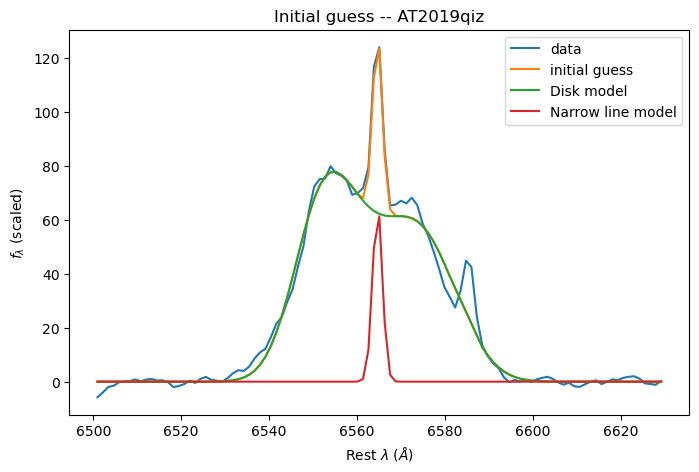

In [11]:
plt.figure(figsize=(8,5))
plt.plot(wl_uncut/(1+fixed['z']),flux_uncut,label='data')
plt.plot(wl/(1+fixed['z']),modelguess,label='initial guess')
plt.plot(wl/(1+fixed['z']),disk,label='Disk model')
plt.plot(wl/(1+fixed['z']),narrowlines,label='Narrow line model')
#plt.axvline(6582); plt.axvline(6588)
plt.xlabel('Rest $\lambda$ ($\AA$)'); plt.ylabel('$f_{\lambda}$ (scaled)')
plt.title('Initial guess -- AT2019qiz'); plt.legend(); plt.show()

In [12]:
lp = logprob_circ_fixeddoublet_freeamplitudes_Halpha(wl, flux, fluxerr, lines, fixed, fitted, diskmins, diskmax)

In [13]:
nll = lambda *args: -lp(*args)
soln = minimize(nll, initial, method='Nelder-Mead')
modelfit = lp.test(soln.x)

print('Best-fit parameter values:', soln.x)

Best-fit parameter values: [2.23478539e+03 1.13691710e+04 2.86031610e+02 8.54551654e+00
 2.50369987e-01 1.10400274e+00 1.08201563e+00 4.10296759e+00
 1.02288195e-10 2.93595081e-01 3.14137160e+01 1.47856446e-09
 6.17588793e+00 4.99989555e+00 1.89637352e+02]


xi1,xi2,broad,angi, <br>
narrowfrac,narrowwidth,narrowwidth2,anglam, <br>
t0,eta,Halphaflux,NIIbflux, <br>
diskflux, amp, aobs <br>

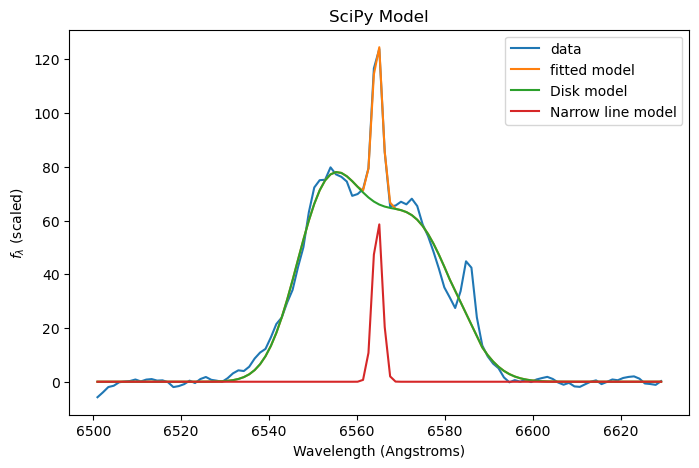

In [14]:
disk,narrowlines = lp.plot(soln.x)
plt.figure(figsize=(8,5))
plt.plot(wl_uncut/(1+fixed['z']),flux_uncut,label='data')
plt.plot(wl/(1+fixed['z']),modelfit,label='fitted model')
plt.plot(wl/(1+fixed['z']),disk,label='Disk model')
plt.plot(wl/(1+fixed['z']),narrowlines,label='Narrow line model')
plt.xlabel('Wavelength (Angstroms)'); plt.ylabel('$f_{\lambda}$ (scaled)')
plt.title('SciPy Model'); plt.legend(); plt.show()

In [19]:
pos = soln.x + 5e-1 * soln.x * np.random.randn(50, soln.x.shape[0])
nwalkers, ndim = pos.shape
type(pos.shape)

tuple

In [14]:
pos = soln.x + 5e-1 * soln.x * np.random.randn(50, soln.x.shape[0])
nwalkers, ndim = pos.shape
filename ='emcee.h5'
backend = emcee.backends.HDFBackend(filename)
backend.reset(nwalkers, ndim)
sampler = emcee.EnsembleSampler(
        nwalkers, ndim, lp, args=(), backend=backend
    )
sampler.run_mcmc(pos, 20000, progress=True)

  6%|▌         | 1173/20000 [39:13<10:21:37,  1.98s/it]/tmp/ipykernel_763906/284404969.py:101: RuntimeWarning: overflow encountered in square
  return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))
 99%|█████████▉| 19812/20000 [11:26:56<07:13,  2.31s/it]  /home/at4206/.conda/envs/Diskfit/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
100%|██████████| 20000/20000 [11:34:01<00:00,  2.08s/it]


State([[ 1.81330613e+03  1.60732673e+04  2.24670912e+02  9.04273193e+00
   4.84510391e+00  1.16692422e+00  1.06764099e+00  1.55072610e+01
   1.35962777e-06 -1.49416262e+00  3.14263201e+01  9.38382798e-04
   6.10700918e+00  4.28124204e+00  1.51075225e+02]
 [ 1.99982031e+03  2.17550286e+04  1.53119450e+02  1.06554659e+01
   2.94502132e+00  1.42926843e+00  1.04691641e+00  2.44051048e+01
   3.52190994e-07 -4.91637985e-01  3.33587648e+01  1.05757028e-05
   8.17109104e+00  4.41136292e+00  1.02639683e+02]
 [ 2.21709100e+03  2.10217530e+04  1.99705468e+02  1.03298611e+01
   1.67142313e+00  1.35114880e+00  6.73662945e-01  1.39808001e+01
   7.28841115e-07 -2.55618027e-01  3.41723481e+01  6.80174453e-04
   6.73925169e+00  4.69955096e+00  1.75915580e+02]
 [ 1.99987002e+03  1.74382249e+04  1.89624091e+02  9.85408637e+00
   4.81216306e+00  1.06455875e+00  1.51188468e+00  5.68452991e+00
   2.29400427e-06 -1.22796122e+00  3.33522791e+01  5.43173958e-04
   7.00013101e+00  4.82541691e+00  1.29778361e+02

In [2]:
from IPython.display import display, Math
flat_samples = sampler.get_chain(discard=20, flat=True)
mcmc_soln=[]
for i,l in enumerate(fitted_labels):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], fitted_labels[i])
    display(Math(txt))
    
    mcmc_soln.append(mcmc[1])

NameError: name 'sampler' is not defined

In [1]:
import corner
fig = corner.corner(
            flat_samples, labels=fitted_labels)
plt.show()

NameError: name 'flat_samples' is not defined

In [ ]:
plt.figure(figsize=(6,6))
fig, axes = plt.subplots(soln.x.shape[0], figsize=(10,3*soln.x.shape[0]), sharex=True)
samples = sampler.get_chain()
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(fitted_labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
    axes[-1].set_xlabel("step number");
plt.show()

In [ ]:
from ultranest.plot import PredictionBand
band = PredictionBand(wl/(1+fixed['z']))
inds = np.random.randint(len(flat_samples), size=10)
for ind in inds:
    sample = flat_samples[ind]
    try:
        modelfit = lp.test(sample)
        band.add(modelfit)
        plt.plot(wl/(1+fixed['z']),modelfit,alpha=0.1)
    except:
        continue
band.line(color='k',label='model')
# add 1 sigma quantile
band.shade(color='k', alpha=0.5)
# add wider quantile (0.01 .. 0.99)
band.shade(q=0.49, color='gray', alpha=0.2);

plt.plot(wl/(1+fixed['z']),flux,label='data')
plt.title('Best fit model found by the emcee sampler')
plt.legend(fontsize=14)
plt.xlabel("x")
plt.ylabel("y");
plt.show()
plt.clf()